### Image generation from adaGAN

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# importing libraries
import os
import sys
import numpy as np
# import h5py
import pickle

In [3]:
# importing adagan files
from adagan_v6 import *
# New functions were added to adagan_v6 and gan_v6 to enable loading the generators from .pb files into the adagan structure.
# Updated code is in the branch 'adaGAN_dev':
#    In adagan_v6.py: load_generators(). In gan_v6.py: load_pb_epoch() + change in generate() line 378

Num GPUs Available:  2
2 Physical GPUs, 1 Logical GPU


In [43]:
# Functions to plot images
from matplotlib.colors import LogNorm
# from mpl_toolkits.mplot3d import Axes3D

# Plot shower shapes
def shower_shape_1d(image, imscale=1, imdpi=100, tag='', save_path=None, save=False, closing=False):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=imscale*(12,2.5), dpi=imdpi)
    xticks = np.arange(0,25)
    ax1.plot(xticks, np.sum(image, axis=(1,2)))
    ax1.set(xlabel='x-axis shape')
    ax2.plot(xticks, np.sum(image, axis=(0,2)))
    ax2.set(xlabel='y-axis shape')
    # ax2.set(yticks=ind + width, yticklabels=ylabels, ylim=[2*width - 1, len(ylabels)])
    ax3.plot(xticks, np.sum(image, axis=(0,1)))
    ax3.set(xlabel='z-axis shape')
    if save:
        if save_path == None:
            print('save_path not passed.')
        else:
            plt.savefig(os.path.join(img_dir, 'shape_1d_' + tag + '.png'), dpi=600, bbox_inches = "tight")
    plt.show()
    if closing:
        plt.close()
    return

# def shower_2d(im):
# Plot 2D images
def shower_shape_2d(image, imscale=1, imdpi=100, tag='', save_path=None, save=False, closing=False):
    """ Plot 2D version of the image
        tag .... to name the image
    """
    xy = np.sum(image, axis=2)
    xz = np.sum(image, axis=1)
    yz = np.sum(image, axis=0)
    
    minim = min(np.min(xy), np.min(xz), np.min(yz)) # to ensure shared colorbar for all three views
    maxim = max(np.max(xy), np.max(xz), np.max(yz))
    if minim == 0:
        minim=0.0000001 # smallest value that does not raise a warning in lognorm transformation
    
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=imscale*(11,3), dpi=imdpi, gridspec_kw={'width_ratios': [1, 1, 1.3]}) # gridspec_kw={'width_ratios': [2, 2, 1]}
    ax1.imshow(xy, norm=LogNorm(vmin=minim, vmax=maxim))
    ax1.set(xlabel='y', ylabel='x')
    ax2.imshow(xz, norm=LogNorm(vmin=minim, vmax=maxim))
    ax2.set(xlabel='z', ylabel='x')
    cs = ax3.imshow(yz, norm=LogNorm(vmin=minim, vmax=maxim))
    ax3.set(xlabel='z', ylabel='y')
    fig.colorbar(cs)
    if save:
        if save_path == None:
            print('save_path not passed.')
        else:
            plt.savefig(os.path.join(img_dir, 'shape_2d_' + tag + '.png'), dpi=600, bbox_inches = "tight")
    plt.show()
    if closing:
        plt.close()
    return


In [4]:
# setting path and loading model parameters
results_dir = '/eos/home-k/kjarusko/Projects/ensemGAN/3Dgan/adaGAN_gpu_v6/run_g10_jan2/'
num_gens = 10
num_epochs = 30

# loading params variable
path = results_dir + 'Info/'
filename = 'adagan_info.pkl'
file = open(path+filename, 'rb')
file_data = pickle.load(file)
file.close()

print(file_data.keys())

params = file_data['params'][0]

# Correction of a bug in the code - params variable was saved only at the beginning -> 'steps_made' was set to 0 and not updated during training
params['steps_made'] = 10

# overwriting the path to data, if needed
# params['data_dir'] = '/eos/home-k/kjarusko/Projects/DataEnerg/unzipped/'

dict_keys(['params', 'beta_vec', 'gan_bestepoch', 'gan_bestval', 't_gan', 'mixdisc_bestepoch', 'mixdisc_best_trainloss', 'mixdisc_best_testloss', 'mixdisc_total_time', 'mixdisc_train_time', 'mixdisc_weights_time', 'mixdisc_preds_time'])


In [5]:
model_dir = 'run_g10_jan2/IntelShare'

#### Generation from a single GAN

##### Loading only the keras model from a pb file

In [6]:
# Necessary to prepare the generator input manually
# Ep = 2-500 GeV
nb_samples = 10
noise = np.random.normal(0, 1, (nb_samples, 200))
gen_aux = np.random.uniform(0.02, 5,(nb_samples,1 )) # E_p/100 vector
generator_input =  np.multiply(gen_aux, noise)

In [7]:
step = 0 # which generator of the ensemble to load (from 0 to params['steps_made']-1 included)
epoch = 16
loaded_model = tf.keras.models.load_model(os.path.join(model_dir, 'Generators', 'gen_{}'.format(step), 'gen_{}_ep_{}'.format(step, epoch)))

In [8]:
# Generate images
output = loaded_model(generator_input)
output = np.array(output) # from tensor to numpy.array
print(output.shape)
output = np.squeeze(output) # remove additional dimension
print(output.shape)

(10, 25, 25, 25, 1)
(10, 25, 25, 25)


In [9]:
# Plot one example of the image

In [10]:
img = output[0]

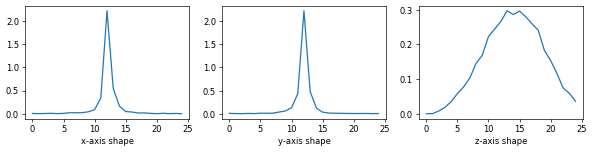

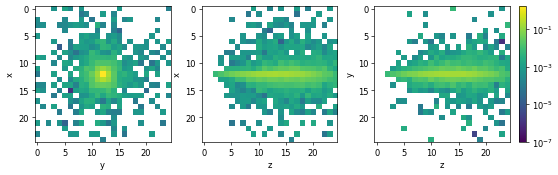

In [45]:
# Plot one sample
shower_shape_1d(img, imdpi=60)
shower_shape_2d(img, imdpi=60)

##### Loading the model throught the generator object

In [50]:
step = 0
epoch = 16
model_path = os.path.join(model_dir, 'Generators', 'gen_{}'.format(step), 'gen_{}_ep_{}'.format(step, epoch))

gen = Generator(params, arch_overwrite="FloG1")
gen.load_pb_epoch(params, path=model_path)
# gen.load_w_epoch(params, step, ada._gens_bestepoch[step]) # if loading weights only


In [61]:
# No need to provide generator input, only the number of images to generate
#   ----> then the images, Ep/100 and ECAL are returned in a tuple (in this order)
output = gen.generate(num=5)
print('output type: {}'.format(type(output)))
images = np.squeeze(np.array(output[0]))
print(images.shape)

# Generator input can still be provided manually if neede (to generate samples for specific Ep values)
#  ----> then only the images are returned
output = gen.generate(generator_input = generator_input)
output = np.squeeze(np.array(output))
print(output.shape)

output type: <class 'tuple'>
(5, 25, 25, 25)
(10, 25, 25, 25)


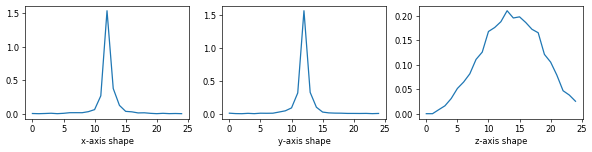

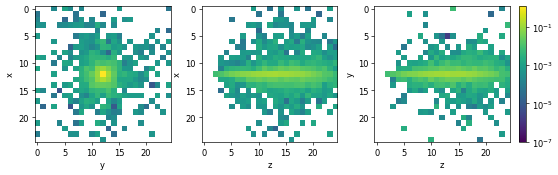

In [63]:
img = images[0]
# Plot one sample
shower_shape_1d(img, imdpi=60)
shower_shape_2d(img, imdpi=60)

#### Generating images from adaGAN

In [70]:
# Initialize the adaGAN
ada = Adagan(params)

# Load generators from pb files with specific location
step_list = [i for i in range(params['steps_made'])]
ep_list = [17, 32, 26, 31, 30, 17, 26, 25, 21, 23]

path_list = [os.path.join(model_dir, 'Generators', 'gen_{}'.format(s), 'gen_{}_ep_{}'.format(s, e)) for s, e in zip(step_list,ep_list)]
ada.load_generators(params, weights_only=False, path = path_list)

print(len(ada.gens_list)) # ada.gens_list is where the generators are loaded


In [73]:
# Run generation automatically
fake_img, ep, ecal = ada.generate_samples(params, num_samples = 10)
# Images already converted to numpy arrays in the correct shape
print(type(fake_img))
print(fake_img.shape)


<class 'numpy.ndarray'>
(10, 25, 25, 25)


In [74]:
# Image generation for a specific Ep
# !!! Input Ep in GeV (i.e. 2-500 GeV, not Ep/100 as before) !!!
fake_img, ep, ecal = ada.generate_samples(params, num_samples = 10, input_Ep = 100*gen_aux)

img = fake_img[0]
print(ep[0])
# Plot one sample
shower_shape_1d(img, imdpi=60)
shower_shape_2d(img, imdpi=60)